# Text Classification
> ## Sentiment Analysis of the Movie Reviews



# Project Overview

>The main aim of this work is evaluating some base classifiers in the sentiment analysis task. To struggle with this problem, two word embedding approaches (Word2Vec, BERT) and SVM classifier has been tried with some text pre-processing techniques on the movie reviews dataset.

> Movie reviews dataset is from IMDB and it contains 50K reviews, half of it is positive and the other half is negative.

# Downloading & Installing the Prerequisites

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2022-05-23 06:38:18--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.6MB/s    in 5.4s    

2022-05-23 06:38:24 (14.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tar -zxvf aclImdb_v1.tar.gz > /dev/null

In [ ]:
!pip3 install bert-embedding

     |████████████████████████████████| 209 kB 5.9 MB/s 
     |████████████████████████████████| 13.8 MB 62.1 MB/s 
     |████████████████████████████████| 29.6 MB 1.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.6.0-py3-none-any.whl size=259930 sha256=cd3840efd9493b61e9bf7f2bd2ada2b7ca6626ac31f842983d2048ddf33e7b32
  Stored in directory: /root/.cache/pip/wheels/a6/41/8f/45bd1c58055d87aee5a71b6756a427ea8d92e506b3a9d17370
Successfully built gluonnlp
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 require

In [ ]:
!pip3 install mxnet-cu100

     |████████████████████████████████| 354.0 MB 3.7 kB/s 
     |████████████████████████████████| 15.7 MB 45.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
mxnet 1.4.0 requires numpy<1.15.0,>=1.8.2, but you have numpy 1.21.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
bert-embedding 1.0.1 requires numpy==1.14.6, but you have numpy 1.21.6 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip3 install sentence-transformers

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.2 MB 47.0 MB/s 
     |████████████████████████████████| 1.2 MB 62.7 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 6.6 MB 65.1 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=8636fa0fb9fcd0b384423fe15860614bc01c31f4d80c46841dd9f1639ed1ce0c
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!ls

aclImdb  aclImdb_v1.tar.gz  sample_data


# Required Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
import re
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import itertools
import mxnet as mx
from bert_embedding import BertEmbedding
import gensim 
from gensim.models import Word2Vec 

# Loading the Dataset


> Our dataset has been divided equally into the training and testing sets. Furthermore, each set contains 12.5K positive and 12.5K negative reviews. The training and testing data were inserted into the Pandas dataframes.



In [ ]:
def loadDataset(data_dir):
    data = {}
    for partition in ["train", "test"]:
        data[partition] = []
        for sentiment in ["neg", "pos"]:
            lable = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, partition, sentiment)
            files = os.listdir(path)
            for f_name in files:
                with open(os.path.join(path, f_name), "r") as f:
                    review = f.read()
                    data[partition].append([review, lable])

    random.seed(4) # to comparision purpose
    random.shuffle(data["train"])
    random.shuffle(data["test"])
    
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

In [ ]:
data_dir = "aclImdb/"
train_data, test_data = loadDataset(data_dir)

The first 5 rows of the training data as follows:

In [ ]:
train_data.head()

,text,sentiment
0,This movie only got a 1 because you can't give...,0
1,Only the most ardent DORIS DAY fan could find ...,0
2,"I really like this movie because in Australia,...",1
3,I have never seen a Barbara Steele movie that ...,1
4,After witnessing his wife (Linda Hoffman) enga...,1


# Cleaning Dataset
> Since this dataset scraped from the web, some HTML codes got mixed up with it. So, cleaning up those by removing HTML tags is needed. Removing the numbers, punctuations, and stop words, replacing negative contraction verb with whose complete forms like won't, splitting compound nouns that are made with hyphen like state-of-the-art (except BERT), and normalizing texts by lowering them would be beneficial.

> Due to BERT embedding was trained on Wikipedia data, for this case, we allow numbers and some of the punctuations like [,  /  ()  :  ;  '] and compound nouns that are made with hyphen which may cause a more reliable embedding to remain in the text. Furthermore, we save "!", "?", and "." to detect the end of the sentence for a later purpose (generate BERT according to each sentence).

> Lastly, white spaces were replaced with only one space.


In [ ]:
def cleanText(text):
    
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'re", " are", text)

    if embedding is not 'BERT':
        text = re.sub(r"[0-9]+", ' ', text)
        text = re.sub(r"-", ' ', text)
    
    
    text = text.strip().lower()
    
    if embedding is 'WORD2VEC_NO_STOP':
        # Remove Stop words
        default_stop_words = set(stopwords.words('english'))
        default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any'})
        stop_words = default_stop_words.union({"'m", "n't", "'d", "'re", "'s",
                                               'would','must',"'ve","'ll",'may'})
    
        word_list = word_tokenize(text)
        filtered_list = [w for w in word_list if not w in stop_words]
        text = ' '.join(filtered_list)
    
    if embedding is not 'BERT':
        # Remove other contractions
        text = re.sub(r"'", ' ', text)
    
    # Replace punctuations with space
    if embedding is 'BERT': # save ! ? . for end of the sentence detection [,/():;']
        filters='"#$%&*+<=>@[\\]^_`{|}~\t\n'
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\?+', '?', text)
    else:
        filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    if embedding is 'BERT':
        text = re.sub(r'\( *\)', ' ', text)

    if embedding is not 'BERT':
        text = ' '.join([w for w in text.split() if len(w)>1])

    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)
    
    text = ''.join(text)

    return text

### Adding cleaned reviews as a column in our data frame.

> As mentioned before, we distinguish between the embedding approaches in data cleaning. So we added 'clean_text' and 'clean_text_bert' columns in our data frame that each column is a cleaned data and prepared for a specific word embedding.

In [ ]:
embedding = 'WORD2VEC_WITH_STOP'
# for Word2Vec with stop words
train_data['clean_text'] = train_data['text'].apply(cleanText)
test_data['clean_text'] = test_data['text'].apply(cleanText)

In [ ]:
embedding = 'BERT'
# for BERT(s)
train_data['clean_text_bert'] = train_data['text'].apply(cleanText)
test_data['clean_text_bert'] = test_data['text'].apply(cleanText)

### A visual comparison of different cleaned data

In [ ]:
# Debugging
print("A review example of dataset before cleaning:", end="\n\n")
print(train_data.iloc[0]['text'], end='\n\n')

print("clean_text:")
print(train_data.iloc[0]['clean_text'], end="\n\n")

print("clean_text_bert:")
print(train_data.iloc[0]['clean_text_bert'], end="\n\n")

A review example of dataset before cleaning:

This movie only got a 1 because you can't give a zero! if you have a weak tummy AT ALL don't watch. animal rights people you don't want to watch either. it makes people vegetarians i swear i witnessed it happen! the only cool parts are the case and the fact that its a true story. its really really super creepy that this guy worked at ADT while he killed people! still feel safe when you punch in that little code? i don't! He had access to every code in Kansas!!!!!! I hated the movie it was not scary it was mentally scaring! Do your self a favor and don;t rent/buy this movie i think it cost about $20 to make that INCLUDES their OVER paid actors!!!!

clean_text:
this movie only got because you can not give zero if you have weak tummy at all do not watch animal rights people you do not want to watch either it makes people vegetarians swear witnessed it happen the only cool parts are the case and the fact that its true story its really really su

# Vectorization

> To introduce our data to the classifier, each review is converted to some numeric features -> This is vectorization.

We have considered both Word2Vec and BERT embedding approaches to our experiments.


<b>Word2Vec</b>
>  Word2Vec consists of two models which are shallow two layer neural networks having one input layer, one hidden layer and one output layer. Word2Vec utilizes two architectures: Continuous Bag of Words and Skip Gram.
The basic idea of Word2Vec is words that occur in similar context tend to be closer to each other in vector space. Gensim library is used to generate word vectors in Python.

<b>Bidirectional Encoder Representations  from Transformers (BERT):</b>
> BERT, published by Google, is pre-trained language model word representation which transforms each word into a vector with a fixed size of 768.</br>

> In this project, we used BERT embedding twice and report their results independently. once, we tokenized each training data into words, then compute BERT embedding of each word, and finally, mean all the BERT vectors of the words as a review representation.
In a second way, we tokenized each training data into sentences and computed the mean of BERT embedding of the sentences to present each training data.

> To utilize BERT embedding, the below library was used: </br>
<a href= "https://pypi.org/project/bert-embedding/">bert-embedding 1.0.1</a>

In [ ]:
def mean(z): # used for BERT and Word2Vec
    return sum(itertools.chain(z))/len(z)

# WORD2VEC

> In this situation, normal data (removing the stop words would have been used as well) is used.

> For the test data, we check that the word already exists in the vocabulary firstly. Otherwise, that word is skipped. Finally, we use mean operator overall word vectors that are also of fixed length and use just a vector to represent the review.

In [ ]:
def embeddToWord2Vec(text):
    words = word_tokenize(text)
    
    if embedding is 'WORD2VEC_WITH_STOP':
        result = [w2v_with_stop_model.wv[w] for w in words if w in w2v_with_stop_model.wv.vocab]
    else:
        result = [w2v_no_stop_model.wv[w] for w in words if w in w2v_no_stop_model.wv.vocab]
    
    feature = [mean(x) for x in zip(*result)]
    return feature

In [ ]:
def wordTokenize(text):
  return word_tokenize(text)

### Word2Vec

> With the Stop Words



In [ ]:
embedding = 'WORD2VEC_WITH_STOP'

In [ ]:
words = train_data['clean_text'].apply(wordTokenize)
w2v_with_stop_model = gensim.models.Word2Vec(words, min_count = 2, size = 100, window = 5) 

In [ ]:
word2vec_with_stop_training_features = train_data['clean_text'].apply(embeddToWord2Vec)
word2vec_with_stop_test_features = test_data['clean_text'].apply(embeddToWord2Vec)

In [ ]:
feature = [x for x in word2vec_with_stop_training_features.transpose()]
word2vec_with_stop_training_features = np.asarray(feature)

feature = [x for x in word2vec_with_stop_test_features.transpose()]
word2vec_with_stop_test_features = np.asarray(feature)

print(word2vec_with_stop_training_features.shape)

(25000, 100)


# BERT

As mentioned before, BERT embedding has been used twice and their results were reported independently. Once, each training data is tokenized into words, then BERT embedding of each word is computed. Lastly, having mean for all the BERT vectors of the words as a review representation. In a second way, each training data is tokenized into sentences and computed the mean of BERT embedding of the sentences to present each training data.

In [ ]:
def embeddToBERT(text):
    sentences = re.split('!|\?|\.',text)
    sentences = list(filter(None, sentences)) 

    if bert_version == 'WORD':
        result = bert(sentences, 'avg') # avg is refer to handle OOV
    
        bert_vocabs_of_sentence = []
        for sentence in range(len(result)):
            for word in range(len(result[sentence][1])):
                bert_vocabs_of_sentence.append(result[sentence][1][word])
        feature = [mean(x) for x in zip(*bert_vocabs_of_sentence)]

    elif bert_version == 'SENTENCE':
        result = bert_transformers.encode(sentences)
        feature = [mean(x) for x in zip(*result)]
  
    return feature

To use the advantage of cloud GPU:

In [ ]:
ctx = mx.gpu(0)
bert = BertEmbedding(ctx=ctx)

In [ ]:
bert_version = 'WORD'
bert_word_training_features = train_data['clean_text_bert'].apply(embeddToBERT)
bert_word_test_features = test_data['clean_text_bert'].apply(embeddToBERT)

In [ ]:
feature = [x for x in bert_word_training_features.transpose()]
bert_word_training_features = np.asarray(feature)

feature = [x for x in bert_word_test_features.transpose()]
bert_word_test_features = np.asarray(feature)

print(bert_word_training_features.shape)

(25000, 768)


# The Classifier

# The Model Training & Evaluation

> Accuracy, confusion matrix, precision, recall, and F-score metrics were calculated and printed for each classifier. Also, ROC curve was plotted. To compute false positives and true positives of a class, roc_curve function, which is in the Scikit Learn library, was used. This function gets labels and target scores as the input parameters. The target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions. So, in order to calculate the target score, decision_function was used for the SVM classifier.

In [ ]:
# A function to plot and print the result
def printResult(y_pred, y_prob):
    acc = accuracy_score(test_data["sentiment"], y_pred)
    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    cm = confusion_matrix(test_data["sentiment"],y_pred)
    print('Confusion Matrix:\n', cm)
    print(classification_report(test_data["sentiment"],y_pred))

    # Plotting
    fpr, tpr, thresholds = roc_curve(test_data["sentiment"], y_prob)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc='lower right')

# SVM

In [ ]:
model = SVC(kernel ='linear', C = 1)

> Word2Vec Version

In [ ]:
# Training 
model.fit(word2vec_with_stop_training_features, train_data["sentiment"])

# Evaluation
y_pred_w2v_with_stop_svm = model.predict(word2vec_with_stop_test_features)
y_prob_w2v_with_stop_svm = model.decision_function(word2vec_with_stop_test_features)

Accuracy: 83.85

Confusion Matrix:
 [[10466  2034]
 [ 2004 10496]]
              precision    recall  f1-score   support

          -1       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Area under the ROC curve : 0.916006


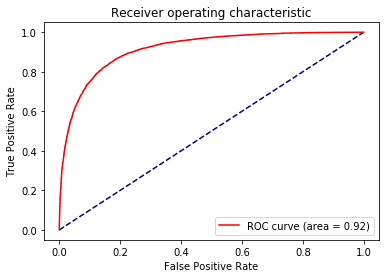

In [ ]:
# Result
printResult(y_pred_w2v_with_stop_svm, y_prob_w2v_with_stop_svm)

> BERT Version

In [ ]:
# Training 
model.fit(bert_word_training_features, train_data["sentiment"])

# Evaluation
y_pred_bert_words_svm = model.predict(bert_word_test_features)
y_prob_bert_words_svm = model.decision_function(bert_word_test_features)

Accuracy: 87.46

Confusion Matrix:
 [[10948  1552]
 [ 1584 10916]]
              precision    recall  f1-score   support

          -1       0.87      0.88      0.87     12500
           1       0.88      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Area under the ROC curve : 0.944653


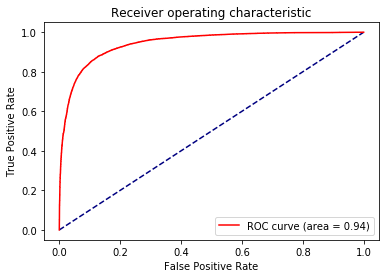

In [ ]:
# Result
printResult(y_pred_bert_words_svm, y_prob_bert_words_svm)